In [88]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
from whma.metrics import rel_err, rank_corr, mse_K_partial
from whma.cumulants import get_C_claw
from numba import autojit

In [89]:
d = 10
mus = 0.0005 * np.ones(d)
Alpha_truth = np.zeros((d,d))
Beta = np.zeros((d,d))
#Alpha_truth = np.ones((d,d)) / 15
for i in range(5):
    for j in range(5):
        if i <= j:
            Alpha_truth[i][j] = 1.
            Beta[i][j] = 50.
for i in range(5,10):
    for j in range(5,10):
        if i >= j:
            Alpha_truth[i][j] = 1.
            Beta[i][j] = 1.
Alpha_truth /= 6
#Alpha_truth = np.ones((d,d)) / 15

In [90]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.585556181944


In [91]:
hMax = 40
hDelta = .001
from math import log
# the criteria for beta_min and beta_max are designed for the exponential case
beta_min = log(1000) / hMax
beta_max = log(10./9.) / hDelta
print("We have")
print("    beta_min = ",beta_min)
print("    beta_max = ",beta_max)

We have
    beta_min =  0.17269388197455343
    beta_max =  105.36051565782634


In [92]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
T_max = 100000000
h.simulate(T_max)
estim = Estim(h, n_threads=8, hDelta=hDelta, hMax=hMax)

# Second order

In [93]:
L = np.array(estim.lam)
C_from_claw = get_C_claw(estim)

In [94]:
@autojit
def A_ij(hk,i,j,H):
    res = 0
    u = 0
    count = 0
    T_ = hk.time
    Z_i = hk.get_full_process()[i]
    Z_j = hk.get_full_process()[j]
    n_i = len(Z_i)
    n_j = len(Z_j)
    if H >= 0:
        for tau in Z_i:
            while u < n_j and Z_j[u] < tau:
                u += 1
            v = u
            while v < n_j and Z_j[v] < tau + H:
                v += 1
            if v < n_j: 
                count += 1
                res += v-u
    else:
        for tau in Z_i:
            while u < n_j and Z_j[u] <= tau:
                u += 1
            v = u
            while v >= 0 and Z_j[v] > tau + H:
                v -= 1
            if v >= 0:
                count += 1
                res += u-1-v
    res -= (i==j)*count
    if count < n_i:
        res *= n_i * 1. / count
    res /= T_
    return res

In [150]:
A = np.zeros((d,d))
B = np.zeros((d,d))
for i in range(d):
    for j in range(d):
        A[i,j] = A_ij(h,i,j,hMax)
        B[i,j] = A_ij(h,i,j,-hMax)
# choosing A or B in the following line give similar results
second_cumul = A+A.T - 2*np.einsum('i,j->ij',L,L)*hMax + np.diag(L)
second_cumul = B+B.T - 2*np.einsum('i,j->ij',L,L)*hMax + np.diag(L)

## Comparison

I define $C_{theory} = R \Sigma R^\top$ with $R = (I_d - ||\Phi||)^{-1}$

In [151]:
from scipy.linalg import inv
R_truth = inv(np.eye(d)-Alpha_truth)
C_theory = np.dot(R_truth,np.dot(np.diag(estim.lam),R_truth.T))
print(rel_err(C_theory,C_from_claw))
print(rel_err(C_theory,second_cumul))

0.00325172137433
0.00325649329732


# Third order

In [97]:
@autojit
def get_K(L_,C_,R_):
    d = len(L_)
    R_ = R_.reshape(d,d)
    K = np.zeros((d,d,d))
    K += np.einsum('im,jm,km->ijk',R_,R_,C_)
    K += np.einsum('im,jm,km->ijk',R_,C_,R_)
    K += np.einsum('im,jm,km->ijk',C_,R_,R_)
    K -= 2*np.einsum('m,im,jm,km->ijk',L_,R_,R_,R_)
    return K

In [98]:
K_theory = get_K(L,C_theory,R_truth)

In [99]:
@autojit
def B_ijk(hk,i,j,k,H):
    res = 0
    u = 0
    x = 0
    count = 0
    T_ = hk.time
    H_ = abs(H)
    Z_i = hk.get_full_process()[i]
    Z_j = hk.get_full_process()[j]
    Z_k = hk.get_full_process()[k]
    n_i = len(Z_i)
    n_j = len(Z_j)
    n_k = len(Z_k)
    for tau in Z_k:
        # work on Z_i
        while u < n_i and Z_i[u] <= tau:
            u += 1
        v = u
        while v >= 0 and Z_i[v] > tau - H_:
            v -= 1
        # work on Z_j
        while x < n_j and Z_j[x] <= tau:
            x += 1
        y = x
        while y >= 0 and Z_j[y] > tau - H_:
            y -= 1
        # check if this step is admissible
        if y >= 0 and v >= 0:
            count += 1
            res += (u-1-v-(i==k))*(x-1-y-(j==k))
    if count < n_k:
        res *= n_k * 1. / count
    res /= T_
    return res

@autojit
def moment3_ijk(hk,i,j,k,A_,F_,L,H):
    res = 0
    res += (i==j)*(i==k)*L[i]
    res += F_[i,j,k] - (i==j)*A_[k,i]
    res += F_[j,k,i] - (k==j)*A_[i,j]
    res += F_[k,i,j] - (i==k)*A_[j,k]
    res += (i==j)*(A_[k,i]+A_[i,k])
    res += (i==k)*(A_[j,i]+A_[i,j])
    res += (k==j)*(A_[k,i]+A_[i,k])
    return res

In [100]:
hMax_ = hMax

In [148]:
F = np.zeros((d,d,d))
for i in range(d):
    for j in range(d):
        for k in range(d):
            F[i,j,k] = B_ijk(h,i,j,k,hMax_)

K_emp = np.zeros((d,d,d))
for i in range(d):
    for j in range(d):
        for k in range(d):
            K_emp[i,j,k] = moment3_ijk(h,i,j,k,B,F,L,hMax_)

# the following lines correspond to the equations (10)-(13)
K_emp -= 4*np.einsum('i,j,k->ijk',L,L,L)*hMax_**2
K_emp -= 2*np.einsum('i,jk->ijk',L,second_cumul)*hMax_
K_emp -= 2*np.einsum('j,ik->ijk',L,second_cumul)*hMax_
K_emp -= 2*np.einsum('k,ij->ijk',L,second_cumul)*hMax_

In [149]:
print(rel_err(K_theory,K_emp))

0.00729306981769


## Estimation procedure for a smaller $hMax$

In [103]:
hMax_ = hMax*.4

In [182]:
F = np.zeros((d,d,d))
for i in range(d):
    for j in range(d):
        for k in range(d):
            F[i,j,k] = B_ijk(h,i,j,k,hMax_)
            
@autojit
def moment3(A_,F_,L,H):
    I = np.eye(len(L))
    M1 = F_.copy()
    M1 -= np.einsum('jk,ij->ijk',I,A_)
    M1 += np.einsum('ij,ik->ijk',I,A_+A_.T)
    M = M1.copy()
    M += np.einsum('jki',M1)
    M += np.einsum('kij',M1)
    M += np.einsum('ij,ik,i->ijk',I,I,L)
    return M
            
K_emp = moment3(B,F,L,hMax_)
# the following lines correspond to the equations (10)-(13)
K_emp -= 4*np.einsum('i,j,k->ijk',L,L,L)*hMax_**2
K_emp -= 2*np.einsum('i,jk->ijk',L,second_cumul)*hMax_
K_emp -= 2*np.einsum('j,ik->ijk',L,second_cumul)*hMax_
K_emp -= 2*np.einsum('k,ij->ijk',L,second_cumul)*hMax_

@autojit
def cumulant3(A_,F_,C_,L,H):
    I = np.eye(len(L))
    M1 = F_.copy()
    M1 -= np.einsum('jk,ij->ijk',I,A_)
    M1 += np.einsum('ij,ik->ijk',I,A_+A_.T)
    M1 -= 2*np.einsum('i,jk->ijk',L,C_)*H
    M = M1.copy()
    M += np.einsum('jki',M1)
    M += np.einsum('kij',M1)
    M += np.einsum('ij,ik,i->ijk',I,I,L)
    M -= 4*np.einsum('i,j,k->ijk',L,L,L)*H**2
    return M

In [183]:
K3 = cumulant3(B,F,second_cumul,L,hMax_)
np.allclose(K3,K_emp)

True

In [105]:
print(rel_err(K_theory,K_emp))

0.00729306981769


# Minimize MSE on third order integrated cumulant

In [106]:
#objective = lambda R: np.linalg.norm(K_emp - get_K(L,C_theory,R))**2 / (2.*d**3)
objective = lambda R: np.linalg.norm(K_emp - get_K(L,second_cumul,R))**2

### L-BFGS doesn't work since the problem is non-convex

In [107]:
from scipy.optimize import fmin_l_bfgs_b
res = fmin_l_bfgs_b(objective,np.random.rand(d**2),approx_grad=1)
R_final = res[0].reshape(d,d)

In [108]:
print(rel_err(R_truth,np.zeros((d,d))))
print(rel_err(R_truth,R_final))

0.3
0.390634118617


### Let's try gradient descent like algorithms

In [109]:
@autojit
def gradient_f_ijk(R_,L_,C_,K_hat,i,j,k):
    d = len(L_)
    grad = np.zeros((d,d))
    grad[i] = R_[j]*C_[k] + R_[k]*C_[j] - 2*L_*R_[j]*R_[k]
    grad[j] = R_[i]*C_[k] + R_[k]*C_[i] - 2*L_*R_[i]*R_[k]
    grad[k] = R_[i]*C_[j] + R_[j]*C_[i] - 2*L_*R_[i]*R_[j]
    k_ijk = np.sum(R_[i]*R_[j]*C_[k] + R_[i]*C_[j]*R_[k] + C_[i]*R_[j]*R_[k] - 2*L_*R_[i]*R_[j]*R_[k])
    return (k_ijk - K_hat[i,j,k])*grad

@autojit
def gradient_f(R_,L_,C_,K_hat):
    d = len(L_)
    K_ = get_K(L_,C_,R_)
    grad_lines = np.einsum('im,jm->ijm',R_,C_)
    grad_lines += np.einsum('im,jm->ijm',C_,R_)
    grad_lines -= 2*np.einsum('m,im,jm->ijm',L_,R_,R_)
    diff_K = K_ - K_hat
    res = np.einsum('ijk,ijm->km',diff_K,grad_lines)
    res += np.einsum('ijk,ikm->jm',diff_K,grad_lines)
    res += np.einsum('ijk,jkm->im',diff_K,grad_lines)
    return res * 1./(d**3)

## Gradient checking

In [110]:
def simple_obj(R):
    K = get_K(L,C_theory,R)
    return .5*np.linalg.norm(K)**2/(d**3)

def simple_grad(R_):
    K = get_K(L,C_theory,R_)
    grad_lines = np.einsum('im,jm->ijm',R_,C_theory)
    grad_lines += np.einsum('im,jm->ijm',C_theory,R_)
    grad_lines -= 2*np.einsum('m,im,jm->ijm',L,R_,R_)
    res = np.einsum('ijk,ijm->km',K,grad_lines)
    res += np.einsum('ijk,ikm->jm',K,grad_lines)
    res += np.einsum('ijk,jkm->im',K,grad_lines)
    return res / (d**3)

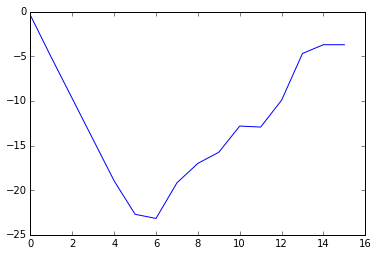

In [111]:
R0 = np.random.rand(d**2).reshape(d,d)
rand_mat = np.zeros((d,d))
a,b = np.random.randint(d), np.random.randint(d)
rand_mat[a,b] += 1.
i,j,k = np.random.randint(d), np.random.randint(d), np.random.randint(d)
erreur = []
res2 = np.einsum('ij,ij',simple_grad(R0),rand_mat)
for u in np.arange(0,-16,-1):
    eps = 10 ** u
    res1 = (simple_obj(R0+eps*rand_mat)-simple_obj(R0-eps*rand_mat))/(2*eps)
    erreur.append(abs(res1-res2)/abs(res2))
plt.plot(np.log(erreur))

# Nesterov Accelerated Gradient

### I've added regularization on $R$

In [112]:
def prox_zero(X, lbd=1.):
    return X

def prox_l1(X, lbd=1.):
    X_abs = np.abs(X)
    return np.sign(X) * (X_abs - lbd) * (X_abs > lbd)

def prox_nuclear(X, lbd=1.):
    U, s, V = np.linalg.svd(X)
    s_thres = prox_l1(s, lbd=lbd)
    return np.dot(U,np.dot(np.diag(s_thres),V))

In [113]:
eta = 1e3
lbd_l1 = 1e-7
lbd_nuc = 1e-6

@autojit
def loss_over_time(maxiter,R0,penalty='zero'):
    R_old = R0.copy()
    R = R0.copy()
    Y = np.empty((d,d))
    loss_arr = np.empty(maxiter)
    rel_err_arr = np.empty(maxiter)
    
    if penalty == 'zero':
        prox = prox_zero
        lbd = 1.
    elif penalty == 'l1':
        prox = prox_l1
        lbd = lbd_l1
    elif penalty == 'nuclear':
        prox = prox_nuclear
        lbd = lbd_nuc
        
    for n in range(maxiter):
        Y[:] = R + (n-2.)/(n+1.)*(R-R_old)
        grad = gradient_f(Y,L,C_theory,K_emp)
        #(i,j,k) = np.random.randint(d), np.random.randint(d), np.random.randint(d)
        #grad = gradient_f_ijk(Y,L,C_theory,K_emp,i,j,k)
        R_old[:] = R
        R[:] = prox(Y - eta*grad,lbd)
        loss_arr[n] = objective(R) + lbd_l1*np.sum(abs(R))
        rel_err_arr[n] = rel_err(R_truth,R)
        
    return rel_err_arr, loss_arr, R

In [132]:
R0_ = np.arange(d**2).reshape(d,d)/(d**2)
res = loss_over_time(5000,R0_,penalty='l1')
rel_err_array = res[0]
loss = res[1]
R_final = res[2]

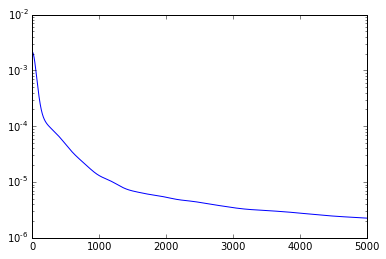

In [133]:
plt.plot(loss)
plt.yscale('log')

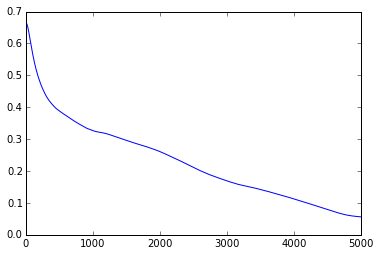

In [134]:
plt.plot(rel_err_array)
#plt.yscale('log')

In [135]:
print(rel_err(R_truth,np.zeros((d,d))))
print(rel_err(R_truth,R_final))

0.3
0.056258792812


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


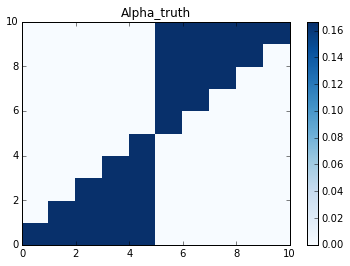

In [179]:
Alpha_pred = np.eye(d) - inv(R_final)

plt.pcolor(Alpha_truth,cmap=plt.cm.Blues)
plt.title("Alpha_truth")
plt.colorbar()
plt.show()
plt.close()

In [180]:
print(rel_err(Alpha_truth,Alpha_pred))

0.0656512281409


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


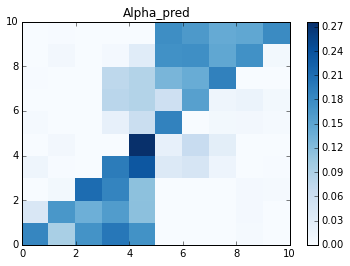

In [181]:
Alpha_pred[Alpha_pred <= 0.] = 0.

plt.pcolor(Alpha_pred,cmap=plt.cm.Blues)
plt.title("Alpha_pred")
plt.colorbar()
plt.show()
plt.close()

In [170]:
print(rel_err(Alpha_truth,Alpha_pred))

0.0617124606288


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


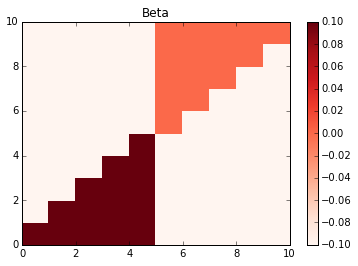

In [131]:
plt.pcolor(np.log(Beta),cmap=plt.cm.Reds)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()